# Machine learning final project -- Wine quality prediction

Explanation for each segment of code and plot are before and/or after every segment of code/plot.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math

from sklearn.linear_model import LinearRegression, ElasticNetCV, Ridge, Lasso, LogisticRegression
from sklearn.metrics import r2_score
from sklearn import datasets, linear_model, preprocessing, svm

import sklearn.model_selection
from sklearn.model_selection import GridSearchCV

from sklearn.metrics.pairwise import pairwise_kernels

import scipy
import time

from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import axes3d

Loading data for white wine:

In [2]:
dfWhite = pd.read_csv('winequality-white.csv',sep=';',header=0,na_values='?')
dfWhite = dfWhite.dropna()

Check if the data are correctly loaded:

In [3]:
dfWhite.head(6)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
5,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6


Wine data are in two sets because white and red wine taste quite differently. Here we will first and mainly use data of white wine to do machine learning because the sample size of white wine is about 3 times larger than that of red wine.

Split the white wine data into variables matrix X and target matrix y:


The first 11 columns are predictor variables and the last column is the target variable `quality`.

In [4]:
variableNames = ['fixed acidity','volatile acidity','citric acid','residual sugar','chlorides',
                 'free sulfur dioxide','total sulfur dioxide','density','pH','sulphates','alcohol']
X = dfWhite[variableNames].values
y = np.ravel(dfWhite[['quality']].values)
# y_copy = y
nums, numf = X.shape

print('number of sample = {0:d}, and number of features = {1:d}'.format(nums,numf))

number of sample = 4898, and number of features = 11


Plotting the distribution of quality of the wines:

Text(0.5, 1.0, 'Quality distribution')

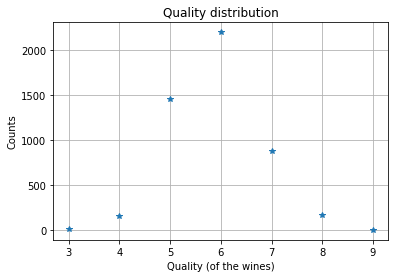

In [5]:
(values,counts) = np.unique(y,return_counts=True)
plt.plot(values, counts,'*')
plt.grid(True)
plt.xlabel('Quality (of the wines)')
plt.ylabel('Counts')
plt.title('Quality distribution')

Observation: the counts of quality have a gaussian distribution, which is normal for this type of data because in reality usually we have more median values than extreme ones.

Let's visualize the maximum, minimum, and mean of each feature with a plot:

In [6]:
Xm = np.mean(X,axis=0) # compute feature mean
Xmax = np.amax(X,axis=0) # feature max
Xmin = np.amin(X,axis=0) # feature min
Xstd = np.std(X,axis=0) # feature std

for i in range(numf):
    print('Feature "{0:s}" has: max = {1:.3f}, min = {2:.3f}, mean = {3:.2f}, and std = {4:.2f}\n'.format(variableNames[i],Xmax[i],Xmin[i],Xm[i],Xstd[i]))


Feature "fixed acidity" has: max = 14.200, min = 3.800, mean = 6.85, and std = 0.84

Feature "volatile acidity" has: max = 1.100, min = 0.080, mean = 0.28, and std = 0.10

Feature "citric acid" has: max = 1.660, min = 0.000, mean = 0.33, and std = 0.12

Feature "residual sugar" has: max = 65.800, min = 0.600, mean = 6.39, and std = 5.07

Feature "chlorides" has: max = 0.346, min = 0.009, mean = 0.05, and std = 0.02

Feature "free sulfur dioxide" has: max = 289.000, min = 2.000, mean = 35.31, and std = 17.01

Feature "total sulfur dioxide" has: max = 440.000, min = 9.000, mean = 138.36, and std = 42.49

Feature "density" has: max = 1.039, min = 0.987, mean = 0.99, and std = 0.00

Feature "pH" has: max = 3.820, min = 2.720, mean = 3.19, and std = 0.15

Feature "sulphates" has: max = 1.080, min = 0.220, mean = 0.49, and std = 0.11

Feature "alcohol" has: max = 14.200, min = 8.000, mean = 10.51, and std = 1.23



Plotting each predictor variable against target y `quality` to visualize how each variavle is related to y with some random variation "jitter" to the y values to facilitate visualization:

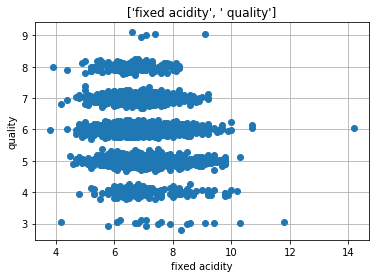

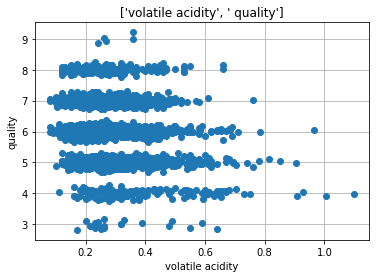

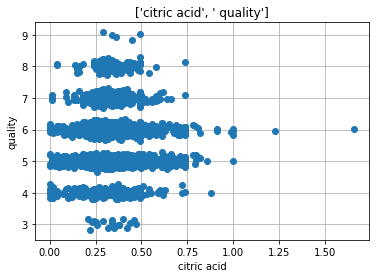

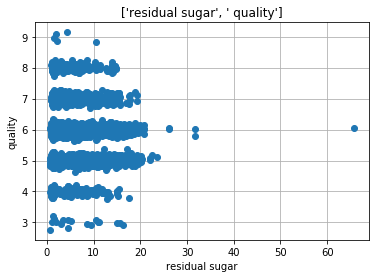

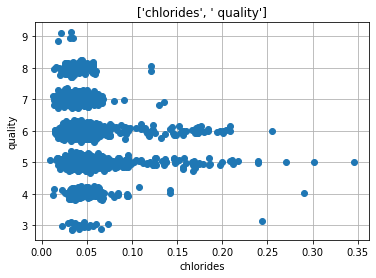

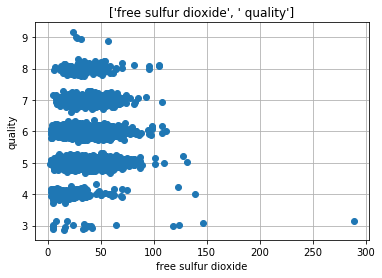

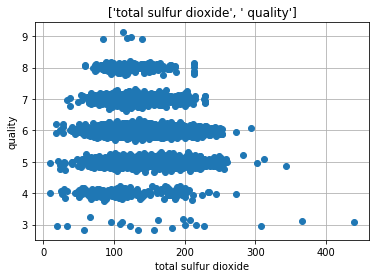

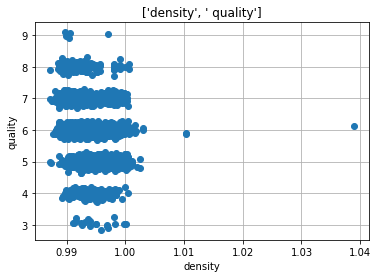

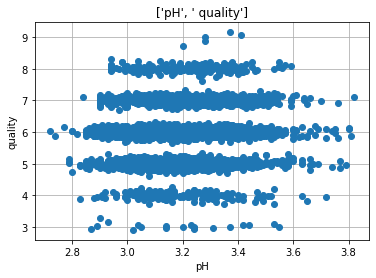

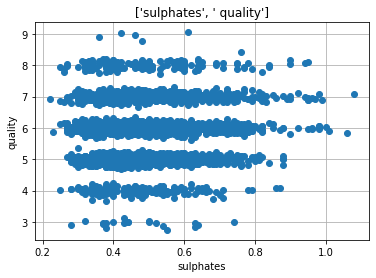

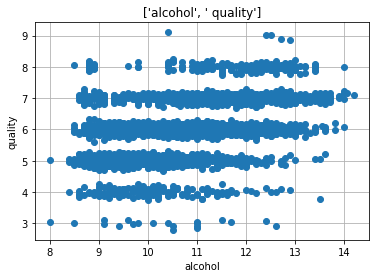

In [7]:
for i in range(11):
    
    plt.figure()
    
    var = .10;
    yj = y + var*np.random.randn(y.shape[0]) # randomly add some "jitter" to help visualize the data
    
    plt.plot(X[:,i],yj,'o')
    plt.grid(True)
    plt.xlabel(variableNames[i])
    plt.ylabel('quality')
    plt.title([variableNames[i],' quality'])
    

Among the 11 plots above, the plot of "fixed quality", "citric acid", "residual sugar", "chlorides", "free sulfur dioxide", and "density" have obvious outliers. We want to perform ormalization and mean centering to see if we can improve accuracy. Also, some variables do not seem to show clear relation with the target variable "quality" (of the wine).

Apply mean centering and standardization with `Xm` and `Xstd` calculated above:

In [8]:
X = (X - Xm[None,:]) / Xstd[None,:]

# Setting a baseline for prediction accuracy
we assign every prediction to be the most frequent element in the data (the element with the largest number of appearance), which is 6. Surprisingly, about 44% of the target variable y is 6, and that gives a "prediction" accuracy of ~44% !

In [9]:
ind = np.argmax(counts) 
print('The most frequent label y is {0:d}'.format(values[ind]))

yhat_baseline = np.ravel(np.ones((nums,1))*6)
# yhat_baseline = np.ravel(np.ones((nums,1)))
acc = np.mean(yhat_baseline == y)
print('Accuracy is: {0:.3f}%'.format(acc*100))

The most frequent label y is 6
Accuracy is: 44.875%


# Multi-linear Rregression without regularization and k-fold validation as another baseline

With multi-linear regression, we will try different train-test split ratio on the white wine data set to compute the accuracies and find out which train/test ratio give the best axxuracy, and to determine whether that best ratio is meaningfu:

In [10]:
def random_train_test_splitter(X, y, trainTestRatio):
    nums = X.shape[0]
    randomArray = np.random.permutation(np.array(range(0,nums)))
    trainLen = int(round(trainTestRatio * nums))
    testLen  = nums - trainLen
    Xtr = X[randomArray[0:trainLen],:]
    Xts = X[randomArray[len(randomArray[0:trainLen]):nums],:]
    ytr = y[randomArray[0:trainLen]]
    yts = y[randomArray[len(randomArray[0:trainLen]):nums]]
    return Xtr, ytr, Xts, yts


Define the multi-linear regression function minimizing the least squared loss, which we have learnt from class:

In [11]:
def my_mult_linear(X,y):
    X = np.concatenate((np.ones((X.shape[0],1)),X),axis=1)
    xt   = np.transpose(X)
    beta = np.linalg.inv(xt@X)@xt@y
    return beta

Now, we can fit a multi-linear regression model using `Xtr, ytr`. Then we will focus on `train loss` and `test loss`, and `accuracy`:

train/test ratio that has smallest train-test loss diffference: [0.98]
train/test ratio that has highest accuracy: [0.95]


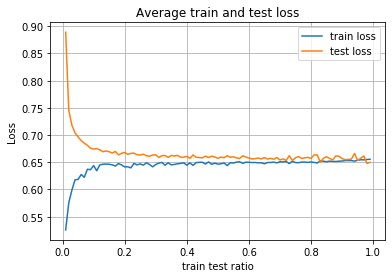

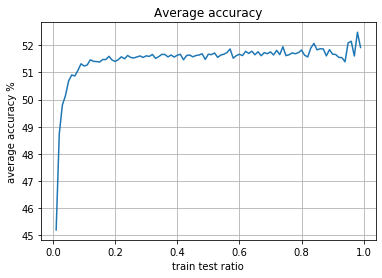

In [12]:
trainTestRatio = np.arange(0.01,1,0.01)

avgTrainLoss = np.zeros((len(trainTestRatio)))
avgTestLoss = np.zeros((len(trainTestRatio)))
avgAcc = np.zeros((len(trainTestRatio)))

loopTimes = 100

for i in range(len(trainTestRatio)):
    
    for times in range(loopTimes):
    
        Xtr, ytr, Xts, yts = random_train_test_splitter(X, y, trainTestRatio[i])

        beta = my_mult_linear(Xtr,ytr)
        
        Xtr_copy = Xtr
        Xtr_copy = np.concatenate((np.ones((Xtr_copy.shape[0],1)),Xtr_copy),axis=1)
        yhat_tr = np.rint(Xtr_copy@beta) # round the predictions because the target "y" (quality) are integers
        
        avgTrainLoss[i] += np.mean((yhat_tr-ytr)**2)
        
        Xts_copy = Xts
        Xts_copy = np.concatenate((np.ones((Xts_copy.shape[0],1)),Xts_copy),axis=1)
        yhat_ts = np.rint(Xts_copy@beta) # round the predictions because the target "y" (quality) are integers
        
        avgTestLoss[i] += np.mean((yhat_ts-yts)**2)
        
        avgAcc[i] += np.mean(yhat_ts == yts)

    if i == 7: # through running experiment, 7 usually performs very good
        yts_7 = yts
        yhat_ts_7 = yhat_ts
        Xtr_7 = Xtr
        Xts_7 = Xts
        ytr_7 = ytr

avgTrainLoss = avgTrainLoss/loopTimes
avgTestLoss = avgTestLoss/loopTimes
avgAcc = avgAcc/loopTimes     
lossDiff = abs(avgTrainLoss-avgTestLoss)

plt.figure()
plt.plot(trainTestRatio,avgTrainLoss,trainTestRatio,avgTestLoss)
plt.grid(True)
plt.title('Average train and test loss')
plt.xlabel('train test ratio')
plt.ylabel('Loss')
plt.legend(['train loss','test loss'])

plt.figure()
plt.plot(trainTestRatio,avgAcc*100)
plt.grid(True)
plt.title('Average accuracy')
plt.xlabel('train test ratio')
plt.ylabel('average accuracy %')

print('train/test ratio that has smallest train-test loss diffference: {}'.format(trainTestRatio[np.where(avgAcc == np.amax(avgAcc))]))
print('train/test ratio that has highest accuracy: {}'.format(trainTestRatio[np.where(lossDiff == np.amin(lossDiff))]))

Although we saw different train/test split ratio does not yield a statistically significant difference in accuracy of predictions, we found that when train/test ratio is around 0.7, we usually get higher accuracy and smaller train-test loss difference. The whole range shows us higher test losses than train loss, so we are not overfittng. With higher accuracy and not overfitting, if we do a train/test split for this dataset, it is better to have the ratio be around `0.7`

Is there a difference in correct prediction rate across target variable y (quality score 0-10)?

`Our guess: a prediction has a larger probability of being correct if the true class label is 5, 6, or 7` because they dominate the class labels. In that case, thay may be considered into the model with more weights. Let's see the contribution to the correct predictions of each class label:

In [13]:
def correct_prediction_percentage(yts, yhat):
    
    (yts_values,yts_counts) = np.unique(yts,return_counts=True)

    correct = yts[yhat == yts]
    (correct_values,correct_counts) = np.unique(correct,return_counts=True)
    
    for i in range(len(yts_values)):
        ind = np.where(correct_values==yts_values[i])
        if np.size(ind)==0: # if there isn't a correct prediction for a particular label in the y-test
            plt.plot(yts_values[i],0,'o')
        else: # if there are correct predictions for a particular label in the y-test
            plt.plot(yts_values[i],(correct_counts[ind]/yts_counts[i])*100,'o')
    
    plt.grid(True)
    plt.xlabel('Quality scores')
    plt.ylabel('Percentage %')
    plt.title('CORRECT prediction % for EACH QUALITY SCORE involved')


We will see below that quality score 6 has the highest correct prediction percentage. It is very likely for the reason that 6 occupy about 45% of all class labels.

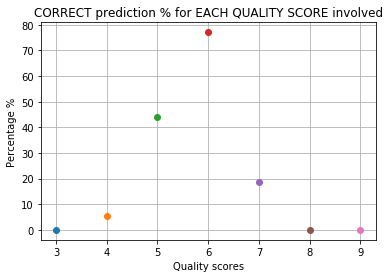

In [14]:
correct_prediction_percentage(yts_7, yhat_ts_7)

Our guess are correct! We saw that there are not quality score 0 to 2 and 10 on the plot, it is simply because they are not even in the dataset (we can check it by looking at the class label distribution plot above). 

# Sklearn's Linear regression, Ridge regression, and ElasticNet-CV regression

We can see from above that the accuracy is relatively low even with preprocessed (standardized) data. Let's try some other methods:

The built-in multi-linear regression: (should not have a large difference than my version of multi-linear regression but worth a try)

Accuracy using built-in linear regression: 51.132%
loss: 0.6691078561917443


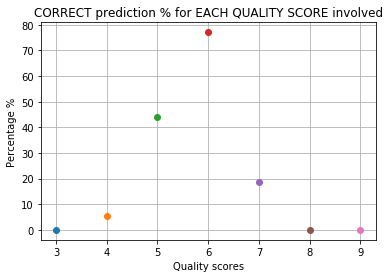

In [15]:
linear = LinearRegression().fit(Xtr_7, ytr_7)
yhat_linear = np.rint(linear.predict(Xts_7))
acc = np.mean(yhat_linear == yts_7)
print('Accuracy using built-in linear regression: {0:.3f}%'.format((acc*100)))
correct_prediction_percentage(yts_7, yhat_linear)
print('loss: {}'.format(np.mean((yhat_linear-yts_7)**2)))

Ridge regression (It uses L2 regularization which shrink all parameters to zeros equally and does not tend to create a sparse model):

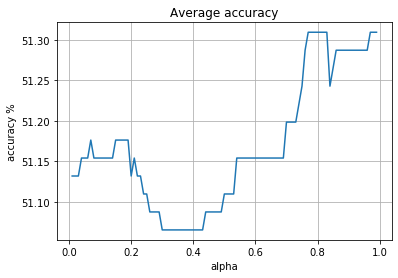

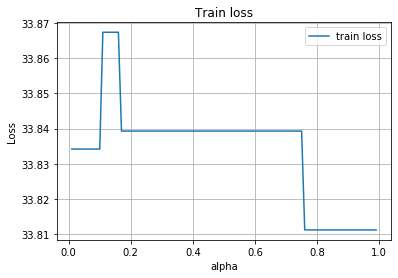

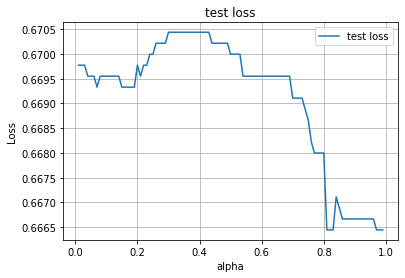

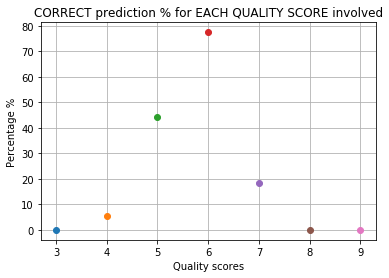

In [16]:
alpha = np.arange(0.01,1.0,0.01)
trainLoss = np.zeros((len(alpha)))
testLoss = np.zeros((len(alpha)))
acc = np.zeros((len(alpha)))

for i in range(len(alpha)):
    
    ridge = Ridge(alpha=alpha[i]).fit(Xtr_7,ytr_7)
    
    yhat_tr = np.rint(Xtr_7@ridge.coef_) # round the predictions because the target "y" (quality) are integers
    trainLoss[i] = np.mean((yhat_tr-ytr_7)**2)

    yhat_ridge = np.rint(ridge.predict(Xts_7))
    testLoss[i] = np.mean((yhat_ridge-yts_7)**2)

    acc[i] = np.mean(yhat_ridge == yts_7)

plt.figure()
plt.plot(alpha,acc*100)
plt.grid(True)
plt.title('Average accuracy')
plt.xlabel('alpha')
plt.ylabel('accuracy %')    

plt.figure()
plt.plot(alpha,trainLoss)
plt.grid(True)
plt.title('Train loss')
plt.xlabel('alpha')
plt.ylabel('Loss')
plt.legend(['train loss'])

plt.figure()
plt.plot(alpha,testLoss)
plt.grid(True)
plt.title('test loss')
plt.xlabel('alpha')
plt.ylabel('Loss')
plt.legend(['test loss'])

plt.figure()
correct_prediction_percentage(yts_7, yhat_ridge)

Lasso regression:

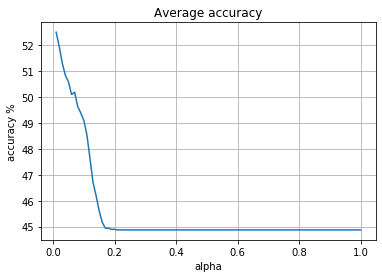

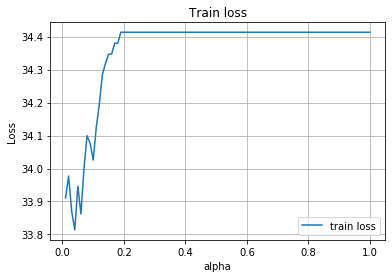

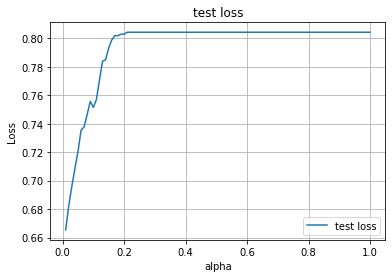

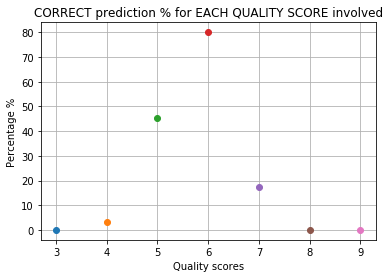

In [17]:
alpha = np.arange(0.01,1.01,0.01)
trainLoss = np.zeros((len(alpha)))
testLoss = np.zeros((len(alpha)))
acc = np.zeros((len(alpha)))

for i in range(len(alpha)):
    
    lasso = Lasso(alpha=alpha[i]).fit(Xtr_7,ytr_7)
    
    yhat_tr = np.rint(Xtr_7@lasso.coef_) # round the predictions because the target "y" (quality) are integers
#     print(yhat_tr-ytr_7)
#     print(yhat_tr)
    trainLoss[i] = np.mean((yhat_tr-ytr_7)**2)

    yhat_lasso = np.rint(lasso.predict(Xts_7))
    testLoss[i] = np.mean((yhat_lasso-yts_7)**2)

    acc[i] = np.mean(yhat_lasso == yts_7)
    if i == 0: # observation, alpha = 0 perform better 
        yhat_lasso_0 = yhat_lasso
        
plt.figure()
plt.plot(alpha,acc*100)
plt.grid(True)
plt.title('Average accuracy')
plt.xlabel('alpha')
plt.ylabel('accuracy %')    

plt.figure()
plt.plot(alpha,trainLoss)
plt.grid(True)
plt.title('Train loss')
plt.xlabel('alpha')
plt.ylabel('Loss')
plt.legend(['train loss'])

plt.figure()
plt.plot(alpha,testLoss)
plt.grid(True)
plt.title('test loss')
plt.xlabel('alpha')
plt.ylabel('Loss')
plt.legend(['test loss'])

plt.figure()
correct_prediction_percentage(yts_7, yhat_lasso_0)

Elastic-Net regression:

0.0008045294586598444 0.5


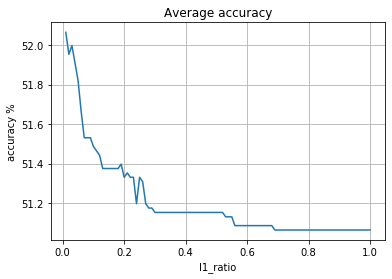

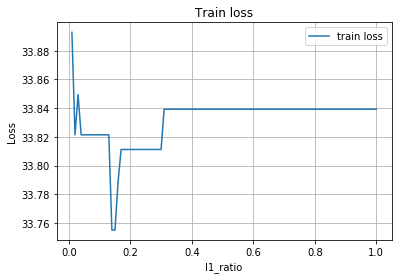

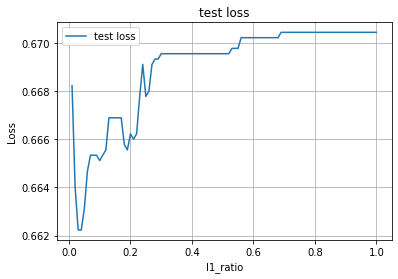

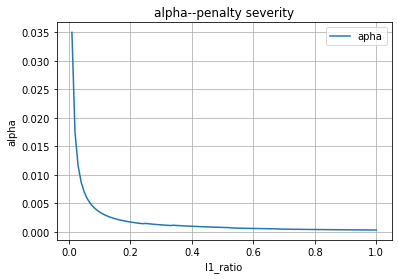

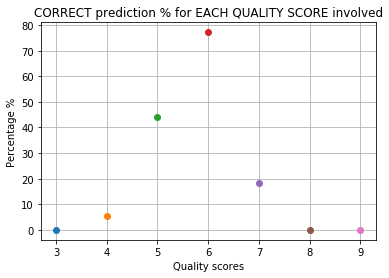

In [18]:
l1_ratio = np.arange(0.01,1.01,0.01)
trainLoss = np.zeros((len(l1_ratio)))
testLoss = np.zeros((len(l1_ratio)))
acc = np.zeros((len(l1_ratio)))
alpha = np.zeros((len(l1_ratio)))

for i in range(len(l1_ratio)):
    
    EN = ElasticNetCV(l1_ratio=l1_ratio[i],cv=5).fit(Xtr_7, ytr_7)
    
    yhat_tr = np.rint(Xtr_7@EN.coef_) # round the predictions because the target "y" (quality) are integers
    trainLoss[i] = np.mean((yhat_tr-ytr_7)**2)

    yhat_EN = np.rint(EN.predict(Xts_7))
    testLoss[i] = np.mean((yhat_EN-yts_7)**2)

    acc[i] = np.mean(yhat_EN == yts_7)
    
    alpha[i] = EN.alpha_
    
plt.figure()
plt.plot(l1_ratio,acc*100)
plt.grid(True)
plt.title('Average accuracy')
plt.xlabel('l1_ratio')
plt.ylabel('accuracy %')    

plt.figure()
plt.plot(l1_ratio,trainLoss)
plt.grid(True)
plt.title('Train loss')
plt.xlabel('l1_ratio')
plt.ylabel('Loss')
plt.legend(['train loss'])

plt.figure()
plt.plot(l1_ratio,testLoss)
plt.grid(True)
plt.title('test loss')
plt.xlabel('l1_ratio')
plt.ylabel('Loss')
plt.legend(['test loss'])

plt.figure()
plt.plot(l1_ratio,alpha)
plt.grid(True)
plt.title('alpha--penalty severity')
plt.xlabel('l1_ratio')
plt.ylabel('alpha')
plt.legend(['apha'])

plt.figure()
correct_prediction_percentage(yts_7, yhat_EN)

EN = ElasticNetCV().fit(Xtr_7, ytr_7)
print(EN.alpha_,EN.l1_ratio)

There is only slightly (~none) improvement to the accuracy of the predictions with built-in linear regression, Ridge regression, and ElasticNet regression.

Conclusion: it seems very hard to obtain a high prediction accuracy with regression models. It may be because nearly half (~44%) of the wines have quality scores of 6, which is very extreme. That might result in the fact that quality score 6 has the highest correct prediction rate as we have seen in the plot above.

# Classification

# Before using relabeling

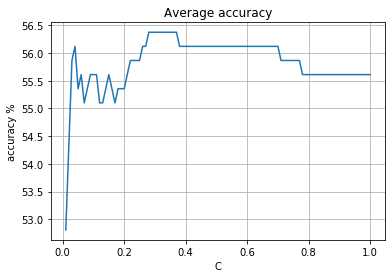

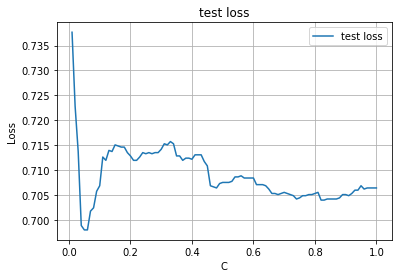

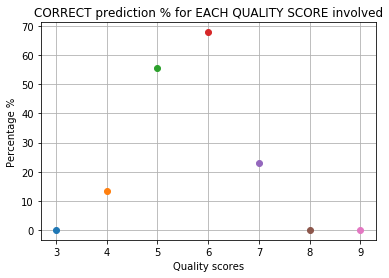

In [19]:
C = np.arange(0.01,1.01,0.01)
trainLoss = np.zeros((len(C)))
testLoss = np.zeros((len(C)))
acc_ = np.zeros((len(C)))

for i in range(len(C)):
    
    logreg = LogisticRegression(penalty='l2',C=C[i],solver='newton-cg').fit(Xtr_7, ytr_7)

    yhat_logreg = np.rint(logreg.predict(Xts_7))
    testLoss[i] = np.mean((yhat_logreg-yts_7)**2)

    acc_[i] = logreg.score(Xtr_7, ytr_7)
    
plt.figure()
plt.plot(C,acc_*100)
plt.grid(True)
plt.title('Average accuracy')
plt.xlabel('C')
plt.ylabel('accuracy %')    

plt.figure()
plt.plot(C,testLoss)
plt.grid(True)
plt.title('test loss')
plt.xlabel('C')
plt.ylabel('Loss')
plt.legend(['test loss'])


plt.figure()
correct_prediction_percentage(yts_7, yhat_logreg)

# Relabeling
What if we separate the target y into only 3 classes and do classification?

Wines with quality score 0-5 will be classified as low quality wines (represented with label "0"), wines with score 6-7 will be good (represented with "1"), while wines with score 8-10 will be excellent (represented with "2").


Relabel the target and randomly divide them into train and test set:

In [20]:
y_relabeled = y
y_relabeled[y_relabeled <= 5] = 0 # 0-5 is class 0
y_relabeled[y_relabeled >= 8] = 2 # 8-10 is class 2
y_relabeled[y_relabeled > 2] = 1 # 6-7 is class 1

randomArray = np.random.permutation(np.array(range(0,nums)))
trainLen = round(.75*nums)
testLen  = nums - trainLen
Xtr = X[randomArray[0:trainLen],:]
Xts = X[randomArray[len(randomArray[0:trainLen]):nums],:]
ytr = y_relabeled[randomArray[0:trainLen]]
yts = y_relabeled[randomArray[len(randomArray[0:trainLen]):nums]]

# Standard (non-kernel) logistic regression

Use scikit-learn's function linear_model.LogisticRegression to fit the model with the lbfgs solver and without regularization:

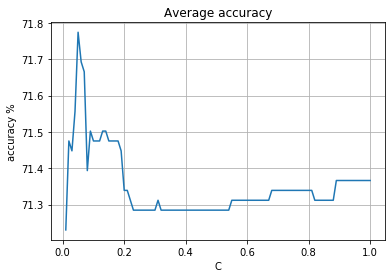

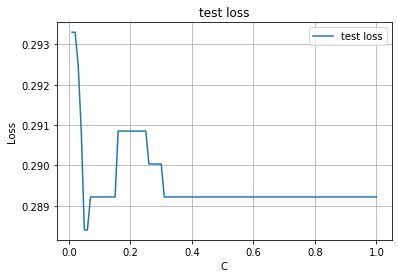

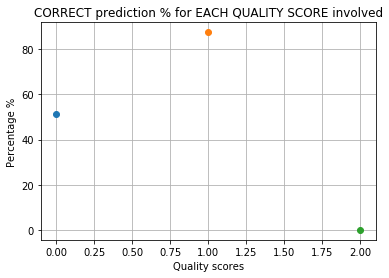

In [21]:
C = np.arange(0.01,1.01,0.01)
trainLoss = np.zeros((len(C)))
testLoss = np.zeros((len(C)))
acc_ = np.zeros((len(C)))

for i in range(len(C)):
    
    logreg = LogisticRegression(penalty='l2',C=C[i],solver='newton-cg').fit(Xtr, ytr)

    yhat_logreg = np.rint(logreg.predict(Xts))
    testLoss[i] = np.mean((yhat_logreg-yts)**2)

    acc_[i] = logreg.score(Xtr, ytr)
    
plt.figure()
plt.plot(C,acc_*100)
plt.grid(True)
plt.title('Average accuracy')
plt.xlabel('C')
plt.ylabel('accuracy %')    

plt.figure()
plt.plot(C,testLoss)
plt.grid(True)
plt.title('test loss')
plt.xlabel('C')
plt.ylabel('Loss')
plt.legend(['test loss'])


plt.figure()
correct_prediction_percentage(yts, yhat_logreg)

# Kernel SVM

In [22]:
gamma = np.arange(0.005,.15,0.02) # [.2,.1, 0.07,.05,.02,.01,.005]
C = np.arange(0.01,10,0.5) #[.01,.1,1,10]
n_jobs=10
parameters = {'kernel':('linear', 'rbf', 'sigmoid'), 'C':C, 'gamma':gamma}
clf = GridSearchCV(svm.SVC(), parameters, n_jobs=n_jobs,pre_dispatch=2*n_jobs)
clf.fit(Xtr, ytr)
yhat_SVM = clf.predict(Xts)
acc = np.mean(yhat_SVM == yts)
print(acc)

# for currGamma in gamma:
    
#     for currC in C: 
    
#         svc = svm.SVC(probability=False,  kernel="rbf", C=currC, gamma=currGamma)
# #         svc = svm.SVC(probability=True,  kernel="rbf", C=currC, gamma=currGamma)
# #         svc = svm.SVC(probability=False,  kernel="linear", C=currC, gamma=currGamma)
# #         svc = svm.SVC(probability=False,  kernel="sigmoid", C=currC, gamma=currGamma)
#         svc.fit(Xtr,ytr)
        
#         ysvm = svc.predict(Xts)
#         acc = np.mean(ysvm == yts)
        
#         print('output count: '+str(outputCount))
#         print('current gamma: '+str(currGamma)+', current C: '+str(currC)+', runtime: '+str(elapsed))
#         print("Test accuracy = %f" % acc)
#         print('')
        
    
    


0.75


# Logistic Regression with rbf kernel

In [23]:
def grad_opt_adapt(grad_func, beta0, nit=5000, lr_init=1e-3):
    beta = beta0
    lr = lr_init
    L,Lgrad = grad_func(beta0)
    for it in range(nit):
        beta1 = beta - lr*Lgrad
        L1, Lgrad1 = grad_func(beta1)
        df_est = Lgrad.T@(beta1-beta)
        alpha = 0.5
        if (L1-L < alpha*df_est) and (L1 < L):
            lr = lr*2
            L = L1
            Lgrad = Lgrad1
            beta = beta1
        else:
            lr = lr/2 
        if (lr < 1e-15):
            break;
    return beta

# The approach here will lead to faster convergence.
def kernel_grad(alpha,K,y,lamb):
    z = K@alpha
    h = 1/(1+np.exp(-z))
    L = np.sum((1-y)*z - np.log(h)) + lamb*np.sum(z*alpha)

    Lgrad = (h-y) + 2*lamb*alpha
    return L, Lgrad

def log_fit(K,y,lamb,nit=1000): #    Function which minizes the logistic regression loss 
    kernel_grad_eval = lambda alpha: kernel_grad(alpha,K,y,lamb)
    alpha0 = np.zeros(K.shape[0])
    alpha = grad_opt_adapt(kernel_grad_eval, alpha0, nit=nit, lr_init=1e-5)
    return alpha

Now, we can iterate through different values of gamma and lamb

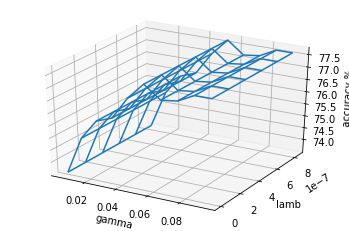

In [24]:
y_binary = np.ravel(dfWhite[['quality']].values)
y_binary[y_binary <= 5] = 0 # 0-5 is class 0
y_binary[y_binary >= 6] = 1 # 6-10 is class 1

randomArray = np.random.permutation(np.array(range(0,nums)))
trainLen = round(.75*nums)
testLen  = nums - trainLen
Xtr = X[randomArray[0:trainLen],:]
Xts = X[randomArray[len(randomArray[0:trainLen]):nums],:]
ytr = y_binary[randomArray[0:trainLen]]
yts = y_binary[randomArray[len(randomArray[0:trainLen]):nums]]


gamma = np.arange(0.005,.1,0.01)
lamb = np.arange(0,1e-6,1e-6/6)
acc = np.zeros(len(gamma)*len(lamb)).reshape(len(lamb),len(gamma))

for i in range(len(gamma)):
    
    for j in range(len(lamb)): 

        K = pairwise_kernels(Xtr, Y=None, metric='rbf',gamma=gamma[i])
        alpha = log_fit(K,ytr,lamb[j],5000)
    
        Ktest = pairwise_kernels(Xts, Xtr, metric='rbf',gamma=gamma[i])

        yhat = (Ktest@alpha)>0
        acc[j,i] = np.mean(yhat == yts)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
GAMMA, LAMB = np.meshgrid(gamma, lamb)
ax.plot_wireframe(GAMMA, LAMB, acc*100, rstride=1, cstride=1)
ax.set_xlabel('gamma')
ax.set_ylabel('lamb')
ax.set_zlabel('accuracy %')
plt.show()